[View in Colaboratory](https://colab.research.google.com/github/nikolay-bushkov/kaist_internship/blob/master/active_learning_for_question_classification.ipynb)

# Predicting question type on the Yahoo dataset

Based on https://developers.google.com/machine-learning/guides/text-classification/, https://github.com/cosmic-cortex/modAL/blob/f8df6021a1343d511d4c9b4c108ec5b683ce5487/examples/ranked_batch_mode.ipynb and https://doi.org/10.1145/3159652.3159733 (https://www.researchgate.net/publication/322488294_Identifying_Informational_vs_Conversational_Questions_on_Community_Question_Answering_Archives)

In [0]:
!pip3 install -q https://github.com/nikolay-bushkov/modAL/archive/feature/sparse_matrix_support.zip

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

## Data preparation

In [0]:
!wget -q http://files.deeppavlov.ai/datasets/yahoo_answers_data/train.csv

In [0]:
!wget -q http://files.deeppavlov.ai/datasets/yahoo_answers_data/valid.csv

In [0]:
train_ds = pd.read_csv('train.csv')

In [0]:
test_ds = pd.read_csv('valid.csv')

In [0]:
X_train_full_raw, y_train_full = train_ds['Title'].values.astype(np.unicode), train_ds['Label'].values

In [0]:
X_test_raw, y_test = test_ds['Title'].values.astype(np.unicode), test_ds['Label'].values

In [0]:
for text, target in zip(X_train_full_raw[2:4], y_train_full[2:4]):
    print("Target: {}".format(target))
    print(text)

Target: 1
Ladies, what strain or type of bud do you like to smoke the most?
Target: 0
How long does it take for an nds rom to upload onto the internet?


In [0]:
transformation_pipe = Pipeline([
    ('featurizer', TfidfVectorizer(stop_words='english', ngram_range=(1, 3))),
    ('feature_selector', SelectKBest(f_classif, k=20000))
])

In [0]:
X_train_full = transformation_pipe.fit_transform(X_train_full_raw, y_train_full)

In [0]:
X_test = transformation_pipe.transform(X_test_raw)

## Baseline model

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
class FCClassifierROCAUC(MLPClassifier):
    """Replace default initialization parameters and scroing (ROC-AUC instead of accuracy)."""
    def __init__(self, hidden_layer_sizes=(32,32), alpha=0.01,
                 batch_size=32, max_iter=1000, early_stopping=True, **kwargs):
        super(FCClassifierROCAUC, self).__init__(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            batch_size=batch_size,
            max_iter=max_iter,
            early_stopping=early_stopping,
            **kwargs)
    def score(self, X, y, sample_weight=None):
        if np.unique(self.classes_).shape[0] == np.unique(y).shape[0] == 2:  # hack for beginning of training
            return roc_auc_score(y, self.predict(X), average='macro', sample_weight=sample_weight)
        else:
            return 0.5

In [0]:
clf = FCClassifierROCAUC()

In [0]:
%time clf.fit(X_train_full, y_train_full)

CPU times: user 4.47 s, sys: 2.37 s, total: 6.84 s
Wall time: 5.07 s


FCClassifierROCAUC(alpha=0.01, batch_size=32, early_stopping=True,
          hidden_layer_sizes=(32, 32), max_iter=1000)

In [0]:
clf.score(X_train_full, y_train_full)

0.9483772859748042

In [0]:
clf.score(X_test, y_test)

0.7526062450119713

## Active learning part

In [0]:
from modAL.models import ActiveLearner

In [0]:
def random_sampling(classifier, X_pool, n_instances=1, **uncertainty_measure_kwargs):
    n_samples = X_pool.shape[0]
    query_idx = np.random.choice(range(n_samples), size=n_instances)
    return query_idx, X_pool[query_idx]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
SEED_SIZE = 0
QUERY_SIZE = 16
QUERY_STEPS = (X_train_full.shape[0] - SEED_SIZE) // QUERY_SIZE

In [0]:
X_seed, X_pool, y_seed, y_pool = train_test_split(X_train_full, y_train_full, train_size=SEED_SIZE, random_state=42)

/home/nab/PycharmProjects/work/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
from modAL.batch import uncertainty_batch_sampling

In [0]:
from tqdm import tqdm

In [0]:
queries = range(1, QUERY_STEPS + 1)

### Random sampling and uncertainty sampling (ranked-batch mode)

In [0]:
X_pool_rs, X_pool_us, y_pool_rs, y_pool_us = X_pool[:], X_pool[:], y_pool[:], y_pool[:]

In [0]:
rs_scores = list()
us_scores = list()
rs_mask = np.ones(X_pool.shape[0], np.bool)
us_mask = np.ones(X_pool.shape[0], np.bool)

In [0]:
rs_learner = ActiveLearner(
    estimator=FCClassifierROCAUC(),
    query_strategy=random_sampling
)
us_learner = ActiveLearner(
    estimator=FCClassifierROCAUC(),
    query_strategy=uncertainty_batch_sampling
)

In [0]:
for query_step in tqdm(queries):
    
    #random
    query_idx_rs, query_inst_rs = rs_learner.query(X_pool_rs, n_instances=QUERY_SIZE)
    rs_learner.teach(query_inst_rs, y_pool_rs[query_idx_rs])
    rs_mask[query_idx_rs] = 0
    X_pool_rs, y_pool_rs = X_pool_rs[rs_mask], y_pool_rs[rs_mask]
    rs_mask = np.ones(X_pool_rs.shape[0], np.bool)
    rs_scores.append(rs_learner.score(X_test, y_test))
    
    #uncertainty (batch) with cosine distances
    query_idx_us, query_inst_us = us_learner.query(X_pool_us, n_instances=QUERY_SIZE, metric='cosine', n_jobs=-2)
    us_learner.teach(query_inst_us, y_pool_us[query_idx_us])
    us_mask[query_idx_us] = 0
    X_pool_us, y_pool_us = X_pool_us[us_mask], y_pool_us[us_mask]
    us_mask = np.ones(X_pool_us.shape[0], np.bool)
    us_scores.append(us_learner.score(X_test, y_test))

  0%|          | 0/225 [00:00<?, ?it/s]/home/nab/PycharmProjects/work/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
100%|██████████| 225/225 [32:25<00:00,  8.65s/it]


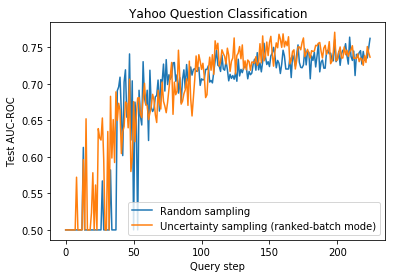

In [0]:
plt.plot(rs_scores, label='Random sampling')
plt.plot(us_scores, label='Uncertainty sampling (ranked-batch mode)')
plt.title('Yahoo Question Classification')
plt.xlabel('Query step')
plt.ylabel('Test AUC-ROC')
plt.legend()

In [0]:
X_pool_ubs, y_pool_ubs = X_pool[:], y_pool[:]

In [0]:
ubs_learner = ActiveLearner(
    estimator=FCClassifierROCAUC(),
    query_strategy=uncertainty_batch_sampling
)

In [0]:
ubs_scores = list()
ubs_mask = np.ones(X_pool.shape[0], np.bool)

In [0]:
for query_step in tqdm(queries):
    #uncertainty (batch) with euclidean
    query_idx_ubs, query_inst_ubs = ubs_learner.query(X_pool_ubs, n_instances=QUERY_SIZE, n_jobs=-2)
    ubs_learner.teach(query_inst_ubs, y_pool_ubs[query_idx_ubs])
    ubs_mask[query_idx_ubs] = 0
    X_pool_ubs, y_pool_ubs = X_pool_ubs[ubs_mask], y_pool_ubs[ubs_mask]
    ubs_mask = np.ones(X_pool_ubs.shape[0], np.bool)
    ubs_scores.append(ubs_learner.score(X_test, y_test))

  0%|          | 0/225 [00:00<?, ?it/s]/home/nab/PycharmProjects/work/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
100%|██████████| 225/225 [22:24<00:00,  5.98s/it]


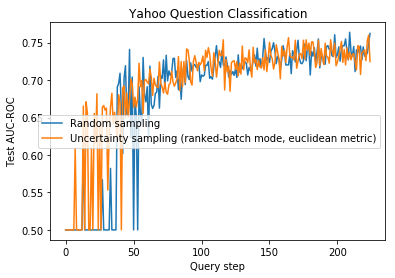

In [0]:
plt.plot(rs_scores, label='Random sampling')
plt.plot(ubs_scores, label='Uncertainty sampling (ranked-batch mode, euclidean metric)')
plt.title('Yahoo Question Classification')
plt.xlabel('Query step')
plt.ylabel('Test AUC-ROC')
plt.legend()